# Look for patterns in Delta NSE

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [4]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [5]:
import sys
sys.path.append("../neuralhydrology")

from neuralhydrology.evaluation.metrics import nse, mse, rmse, kge, fdc_fms, fdc_fhv, fdc_flv, calculate_all_metrics, calculate_metrics

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read AWS Trained Models

In [7]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_preds = xr.open_dataset(data_dir / "RUNOFF/ealstm_epoch30_ensemble2/results.nc")
ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]
ealstm_preds = ealstm_preds.rename({"discharge_spec_obs": "obs", "discharge_spec_sim": "sim"})
ealstm_df = ealstm_preds.to_dataframe().reset_index()

In [8]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble
lstm_df = lstm_preds.to_dataframe().reset_index()

In [9]:
metric_df = pd.read_csv(data_dir / "runs/ensemble/metric_df.csv", index_col=0)
metric_df.columns = [c.lower() for c in metric_df.columns]
metric_df.head()

,station_id,nse,kge,mse,fhv,fms,flv
0,10002,0.898328,0.857653,0.229347,-10.042169,20.175607,4.281218
1,10003,0.926555,0.881110,0.111980,-6.074578,1.342742,28.237229
2,1001,0.876090,0.920412,0.509755,3.647934,-23.746845,70.234474
3,101002,0.757246,0.647206,0.300506,-25.176707,-4.734227,73.409471
4,101005,0.824926,0.796430,0.208704,-18.346511,1.971726,45.197245


# FUSE Data

In [10]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [11]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [12]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [13]:
fuse_data

<xarray.Dataset>
Dimensions:          (station_id: 519, time: 4018)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Match Stations / Times

In [14]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

In [15]:
# lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
# ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Errors

In [16]:
from scripts.drafts.calculate_error_scores import calculate_ml_errors, error_func

In [17]:
ealstm_metric_df = calculate_ml_errors(ealstm_preds).set_index("station_id")
lstm_metric_df = calculate_ml_errors(lstm_preds).set_index("station_id")

In [18]:
metric_df["rmse"] = np.sqrt(metric_df["mse"])
lstm_metric_df["rmse"] = np.sqrt(lstm_metric_df["mse"])
ealstm_metric_df["rmse"] = np.sqrt(ealstm_metric_df["mse"])
display(metric_df.set_index("station_id").sort_index().head())
display(lstm_metric_df.sort_index().head())

,nse,kge,mse,fhv,fms,flv,rmse
station_id,,,,,,,
1001,0.876090,0.920412,0.509755,3.647934,-23.746845,70.234474,0.713971
2001,0.796159,0.737755,1.295476,-23.338750,-8.885240,8.945649,1.138190
2002,0.799168,0.721571,2.248968,-26.614591,-20.047770,54.950795,1.499656
3003,0.878744,0.851921,4.253649,-13.508330,-20.236829,54.121467,2.062438
4001,0.872644,0.860455,1.789749,-4.687964,-18.653824,39.811433,1.337815


,nse,kge,mse,bias,rmse
station_id,,,,,
1001,0.876090,0.920412,0.509755,4.266320,0.713971
2001,0.796159,0.737755,1.295476,-12.189085,1.138190
2002,0.799168,0.721571,2.248968,-7.375567,1.499656
3003,0.878744,0.851921,4.253648,-0.086631,2.062437
4001,0.872644,0.860455,1.789749,-3.644160,1.337815


# FUSE - Calculate from Sim

In [19]:
from scripts.drafts.calculate_error_scores import FuseErrors

In [20]:
f = FuseErrors(fuse_data)
fuse_errors = f.fuse_errors
fuse_metric_df = fuse_errors

nse: 4it [00:07,  1.98s/it]
kge: 4it [00:08,  2.05s/it]
bias: 4it [00:05,  1.25s/it]
rmse: 4it [00:05,  1.27s/it]


In [59]:
fuse_bias = f.get_metric_df("bias")
fuse_nse_df = f.get_metric_df("nse")
fuse_kge_df = f.get_metric_df("kge")

topmodel_metrics = f.get_model_df("TOPMODEL")

# Calculate delta Metrics (all dataset)

In [203]:
from scripts.drafts.calculate_error_scores import DeltaError

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data)
all_preds = processor.all_preds
errors_dict = processor.calculate_all_errors(all_preds)

6it [00:34,  5.69s/it]


## calculate seasonal differences in scores

In [389]:
seasonal_deltas = defaultdict(dict)
for season in ["DJF", "MAM", "JJA", "SON"]:
    _preds = all_preds.sel(time=all_preds["time.season"] == season)
    seasonal_errors = processor.calculate_all_errors(_preds)
    seasonal_deltas[season]["LSTM"], seasonal_deltas[season]["EALSTM"] = processor.calculate_all_delta_dfs(seasonal_errors)
    seasonal_deltas[season]["raw"] = seasonal_errors

6it [00:17,  2.94s/it]
6it [00:17,  2.92s/it]
6it [00:17,  2.93s/it]
6it [00:17,  2.84s/it]


In [421]:
# display(seasonal_deltas["MAM"]["LSTM"]["nse"].head())
# display(seasonal_deltas["DJF"]["LSTM"]["nse"].head())

In [343]:
lstm_delta, ealstm_delta = processor.calculate_all_delta_dfs(errors_dict)

In [422]:
lstm_delta["nse"].head(2)

,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM
station_id,,,,,
1001,0.121787,0.109569,0.089872,0.070694,0.006240
2001,0.140996,0.111082,0.109437,0.096187,0.013621


In [377]:
for season in ["DJF", "MAM", "JJA", "SON"]:
    _preds = all_preds.sel(time=all_preds["time.season"] == season)
    seasonal_errors = processor.calculate_all_errors(_preds)
    seasonal_deltas[season]["LSTM"], seasonal_deltas[season]["EALSTM"] = processor.calculate_all_delta_dfs(errors_dict)
    seasonal_deltas[season]["raw"] = seasonal_errors


6it [00:17,  2.90s/it]
6it [00:17,  2.96s/it]
6it [00:17,  2.89s/it]
6it [00:18,  3.03s/it]


#### using the kratzert functions (more error metrics)

In [ ]:
if False:
    # calculate all error metrics
    lstm_kratzert_results, ealstm_kratzert_results = processor.kratzert_errors(all_preds)
    
kratzert_results_file = data_dir / "RUNOFF/kratzert_results.pkl"
if not kratzert_results_file.exists():
    model_results = calc_kratzert_error_functions(all_preds)
    pickle.dump(results, kratzert_results_file.open("wb"))
else:
    results = pickle.load(kratzert_results_file.open("rb"))
    
if False:
    kra_lstm_delta_dict = processor.calculate_all_kratzert_deltas(results, ref_model="LSTM")
    kra_lstm_delta = processor.get_formatted_dataframe(lstm_delta_dict, format="metric")

    kra_ealstm_delta_dict = processor.calculate_all_kratzert_deltas(results, ref_model="EALSTM")
    kra_ealstm_delta = processor.get_formatted_dataframe(ealstm_delta_dict, format="metric")

In [423]:
lstm_metric_deltas["NSE"].head(2)

,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM
1001,0.121787,0.109569,0.089872,0.070694,0.006240
2001,0.140996,0.111082,0.109437,0.096187,0.013621


In [320]:
display(lstm_delta["nse"].describe())
# display(ealstm_delta["nse"].describe())
display(lstm_metric_deltas["NSE"].describe())

,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM
count,518.000000,518.000000,518.000000,518.000000,667.000000
mean,0.156288,0.173227,0.426942,0.198212,0.033535
std,0.178332,0.851758,2.617494,1.010339,0.072132
min,-0.350125,-0.310235,-0.247587,-0.385706,-0.454244
25%,0.065370,0.058939,0.068732,0.045756,0.009777
50%,0.102136,0.087175,0.101335,0.066714,0.021960
75%,0.174605,0.139779,0.182483,0.111886,0.042323
max,1.443369,18.093867,55.277038,20.590447,1.049512


,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM
count,518.000000,518.000000,518.000000,518.000000,667.000000
mean,0.156288,0.173227,0.426942,0.198212,0.033535
std,0.178332,0.851758,2.617494,1.010339,0.072132
min,-0.350125,-0.310235,-0.247587,-0.385706,-0.454244
25%,0.065370,0.058939,0.068732,0.045756,0.009777
50%,0.102136,0.087175,0.101335,0.066714,0.021960
75%,0.174605,0.139779,0.182483,0.111886,0.042323
max,1.443369,18.093867,55.277038,20.590447,1.049512


# Explore Delta NSEs

In [212]:
lstm_delta_nse = lstm_delta["nse"]

In [361]:
def boxplot_deltas(deltas: pd.DataFrame, metric: str, ylim=[-1 ,1], ref_model: str = "LSTM"):
    sns.boxplot(data=deltas[metric], palette=sns.color_palette())
    ax = plt.gca()
    ax.set_ylim(ylim)
    ax.axhline(0, ls=":", color="k", label="No Improvement")
    ax.set_ylabel(f"$\Delta${metric}")
    ax.legend()
    ax.set_title(f"$\Delta${metric} for each Model vs. {ref_model}")
    sns.despine()

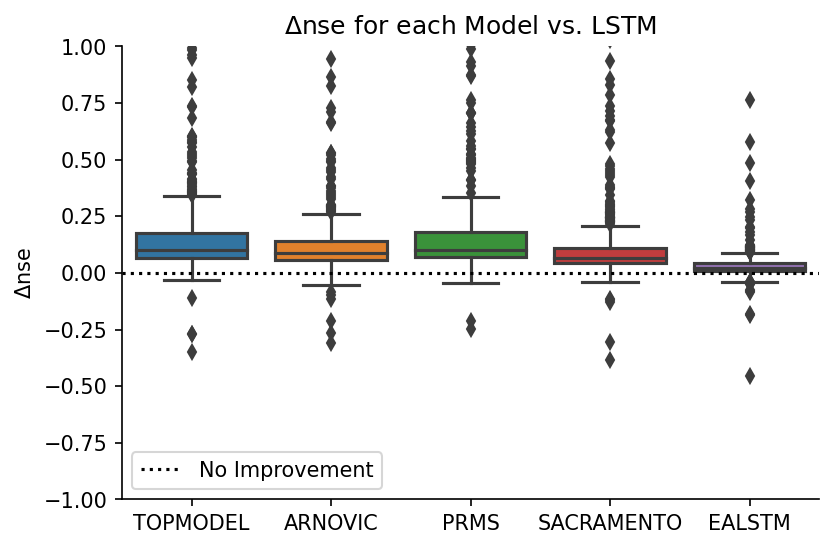

In [364]:
boxplot_deltas(lstm_delta, metric="nse")

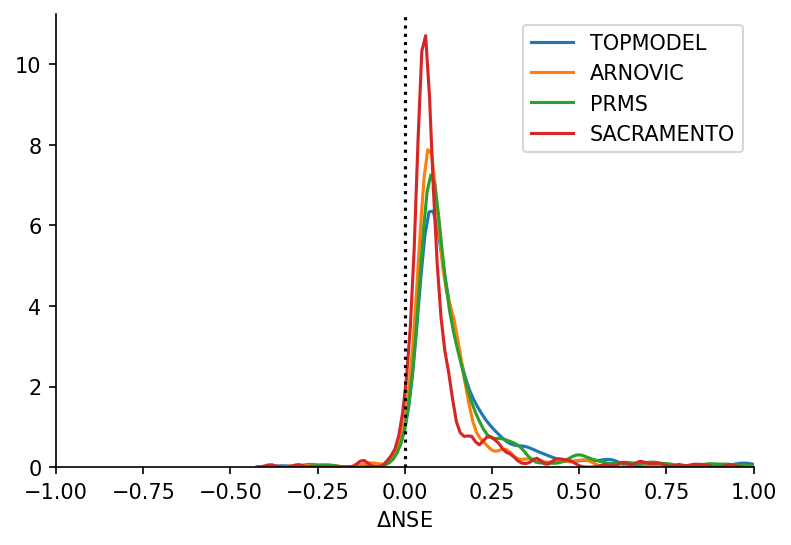

In [403]:
from typing import Tuple

def kde_plot_deltas(delta_df: pd.DataFrame, metric: str = "nse", xlim: Tuple[float] = (-1, 1)):
        kde_kws = {"clip": (-1, 1)}
        hist_kws = {"range": (-1, 1), "density": True}

        f, ax = plt.subplots()
        [
            sns.distplot(delta_df[metric][c], ax=ax, kde_kws=kde_kws, hist_kws=hist_kws, hist=False, label=c) 
            for c in delta_df[metric].columns if c != "EALSTM"
        ]
        ax.set_xlim((-1, 1))
        ax.axvline(0, ls=":", color="k")
        ax.set_xlabel("$\Delta$NSE")
        ax.legend()
        sns.despine()
        
        
kde_plot_deltas(lstm_delta, metric="nse", xlim=(-1, 1))

In [445]:
lstm_seasonal_dfs = {}
for season in ["DJF", "MAM", "JJA", "SON"]:
    lstm_seasonal_dfs[season] = seasonal_deltas[season]["LSTM"]["nse"]
    
ealstm_seasonal_dfs = {}
for season in ["DJF", "MAM", "JJA", "SON"]:
    ealstm_seasonal_dfs[season] = seasonal_deltas[season]["EALSTM"]["nse"]

In [395]:
# display(lstm_seasonal_dfs["DJF"].head())
# display(lstm_seasonal_dfs["MAM"].head())

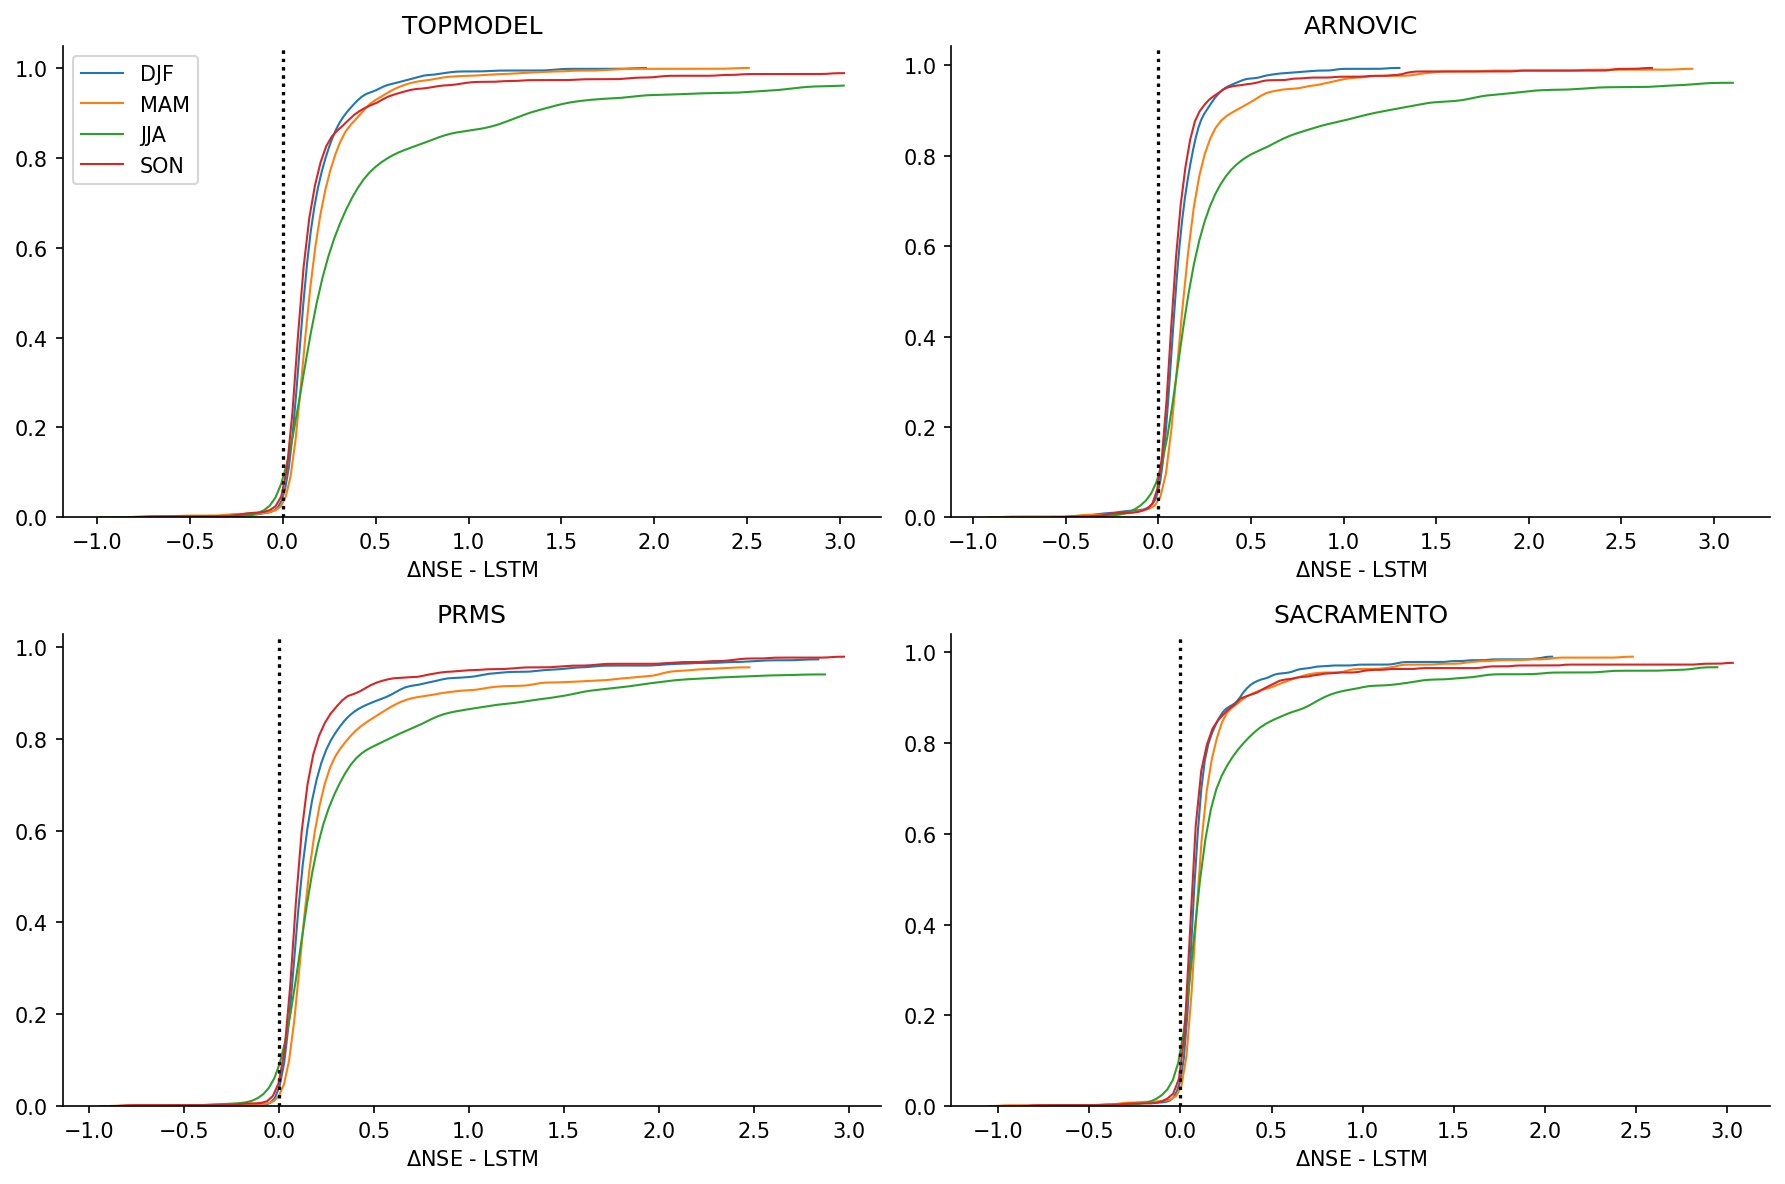

In [459]:
# LSTM
metric = "nse"
ref_model = "LSTM"

def plot_seasonal_ecdfs(seasonal_deltas: DefaultDict, metric: str = "nse", ref_model: str = "LSTM", clip: Tuple[float] = (-1, 3)):
    fig, axs = plt.subplots(2, 2, figsize=(6*2, 4*2))

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax = axs[np.unravel_index(ix, (2, 2))]
        for season in ["DJF", "MAM", "JJA", "SON"]:
            sns.distplot(
                seasonal_deltas[season][ref_model][metric].loc[:, model].dropna(), 
                label=season, 
                kde_kws = {"clip": (-1, 3), "linewidth":1, "cumulative": True}, 
                hist=False, ax=ax
            )

            ax.axvline(0, ls=":", color="k", alpha=0.6)
            ax.set_xlabel(f"$\Delta${metric.upper()} - {ref_model}")
            ax.set_title(model)
            if ix != 0:
                ax.get_legend().remove()

            sns.despine()

    plt.tight_layout()
    
plot_seasonal_ecdfs(seasonal_deltas, metric="nse", ref_model="LSTM")

In [458]:
# plot_seasonal_ecdfs(seasonal_deltas, ref_model="EALSTM", metric="bias")

In [590]:
def plot_static_feature_ordered_scatter(
    delta_data: Dict[str, pd.DataFrame],
    metric: str = "nse", 
    ylim: Tuple[float] = (-0.5, 1.6), 
    feature: str = "aridity",
    kwargs: Dict = {},
):
    data = delta_data[metric].join(static[feature].to_dataframe())

    f, axs = plt.subplots(2, 2)

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax = axs[np.unravel_index(ix, (2, 2))]
        s = ax.scatter(
            np.arange(len(data[model])), 
            data[model].sort_values(), 
            c=data[feature],
            **kwargs
        )
        ax.axhline(ls=":", color="k", alpha=0.5, label="No Improvement")
        ax.set_title(f"{model} Delta {metric.upper()}")
        ax.set_ylim(ylim)
        sns.despine()
    
    # colorbar
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(s, cax=cbar_ax)
    cbar.set_label(feature.capitalize())

    
def plot_static_feature_scatter(
    delta_data: Dict[str, pd.DataFrame],
    metric: str = "nse", 
    ylim: Tuple[float] = (-0.5, 1.6), 
    feature: str = "aridity",
    kwargs: Dict = {},
):
    data = delta_data[metric].join(static[feature].to_dataframe())

    f, axs = plt.subplots(2, 2)

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax = axs[np.unravel_index(ix, (2, 2))]
        s = ax.scatter(
            data[model].sort_values(), 
            c=data[feature],
            **kwargs
        )
        ax.axhline(ls=":", color="k", alpha=0.5, label="No Improvement")
        ax.set_title(f"{model} Delta {metric.upper()}")
        ax.set_ylim(ylim)
        sns.despine()
    
    # colorbar
    f.tight_layout()
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = f.colorbar(s, cax=cbar_ax)
    cbar.set_label(feature.capitalize())


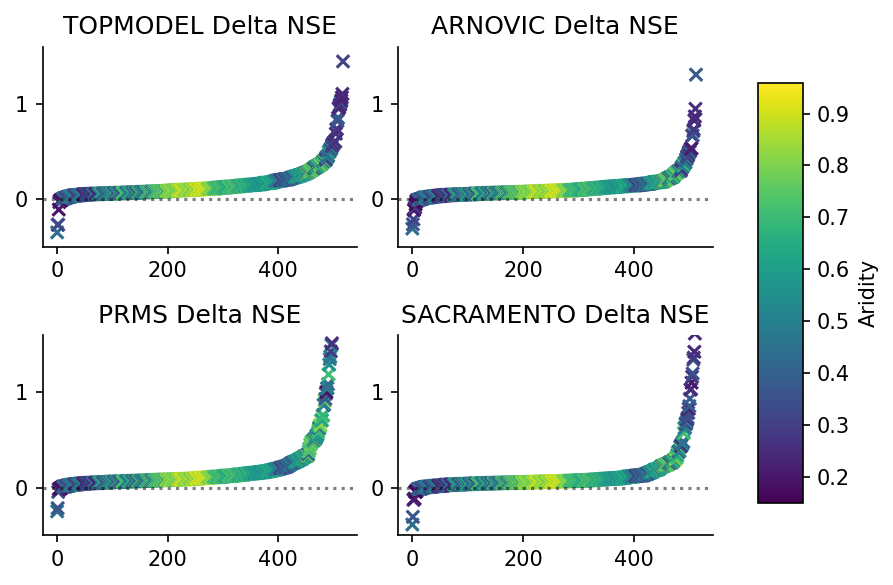

In [593]:
plot_static_feature_ordered_scatter(lstm_delta, metric="nse", feature="aridity", kwargs={"s": None, "marker":"x"})

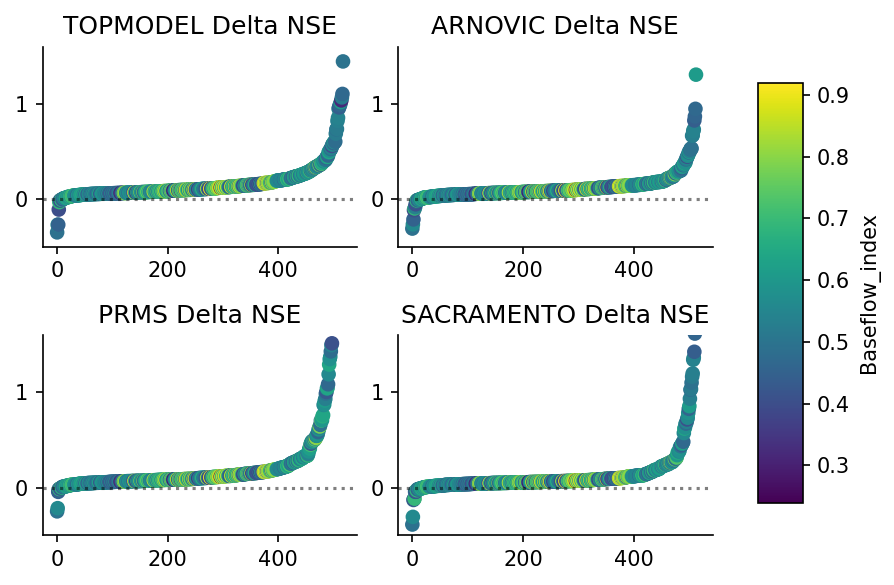

In [594]:
plot_static_feature_scatter(lstm_delta, metric="nse", feature="baseflow_index", kwargs={"vmin":None, "vmax":None})
# plot_static_feature_scatter(lstm_delta, metric="nse", feature="area")

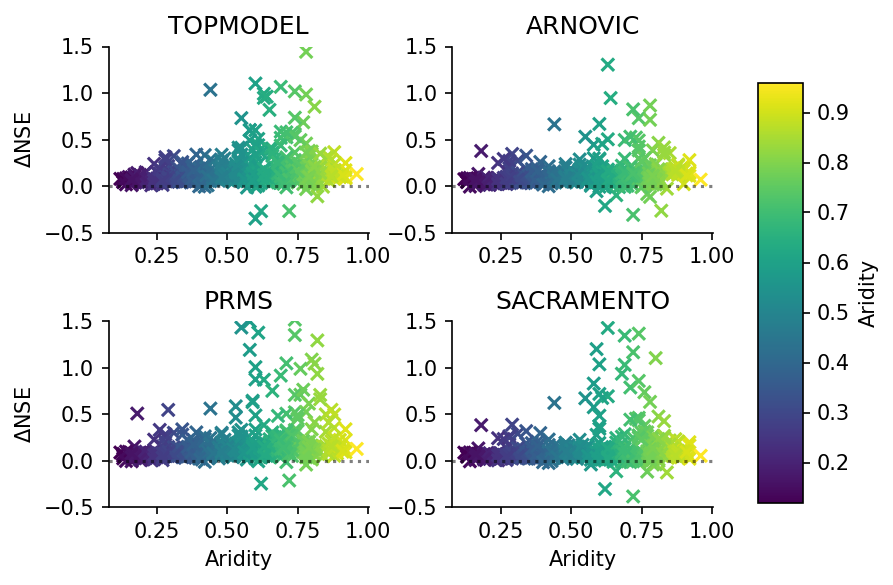

In [614]:
# [v for v in static.data_vars]
delta_data = lstm_delta
feature = "aridity"
metric = "nse"
kwargs = {"vmin": None, "vmax": None, "marker": "x"}

data = delta_data[metric].join(static[feature].to_dataframe())

f, axs = plt.subplots(2, 2)

for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
    ax = axs[np.unravel_index(ix, (2, 2))]
    s = ax.scatter(
        data[feature],
        data[model],
        c=data[feature],
        **kwargs
    )
    ax.axhline(ls=":", color="k", alpha=0.5, label="No Improvement")
    ax.set_title(f"{model}")
    ax.set_ylim(ylim)
    
    if np.unravel_index(ix, (2, 2))[1] == 0:
        ax.set_ylabel(f"$\Delta${metric.upper()}")
    if np.unravel_index(ix, (2, 2))[0] == 1:
        ax.set_xlabel(f"{feature.capitalize()}")
    sns.despine()

# colorbar
f.tight_layout()
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = f.colorbar(s, cax=cbar_ax)
cbar.set_label(feature.capitalize())

# Plot seasonality

In [442]:
doy_mean = ds["discharge_spec"]
doy_mean["doy"] = doy_mean["time.dayofyear"]
plot_data = doy_mean.groupby("doy").mean(["station_id", "time"])

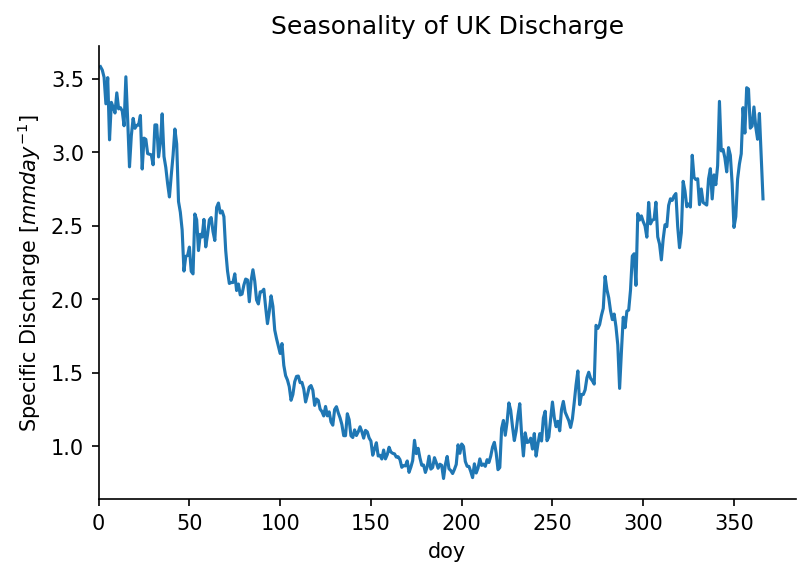

In [441]:
fig, ax = plt.subplots()
plot_data.plot()
ax.set_xlim(0, None)
ax.set_title("Seasonality of UK Discharge")
ax.set_ylabel("Specific Discharge [$mm day^{-1}$]")
sns.despine()

# Table of performances

In [226]:
ealstm_delta_nse = ealstm_delta["nse"]

In [227]:
display(lstm_delta_nse.median())
display(ealstm_delta_nse.median())

TOPMODEL      0.102136
ARNOVIC       0.087175
PRMS          0.101335
SACRAMENTO    0.066714
EALSTM        0.020989
dtype: float64

TOPMODEL      0.078454
ARNOVIC       0.065675
PRMS          0.079217
SACRAMENTO    0.046756
LSTM         -0.021960
dtype: float64

### % Delta NSE > 0

In [427]:
lstm_delta_nse_ltx = lstm_delta_nse.dropna().drop("EALSTM", axis=1)
ealstm_delta_nse_ltx = ealstm_delta_nse.dropna().drop("LSTM", axis=1)

In [430]:
# "% Basins where $\Delta$NSE > 0"
latex_df = pd.concat(
    [
        ((lstm_delta_nse_ltx > 0).sum(axis=0) / lstm_delta_nse_ltx.count()).to_frame().rename({0: "LSTM"}, axis=1),
        ((ealstm_delta_nse_ltx > 0).sum(axis=0) / ealstm_delta_nse_ltx.count()).to_frame().rename({0: "EA LSTM"}, axis=1)
    ], axis=1
)
# latex_df.columns = [("% Basins where $\Delta$NSE > 0", "LSTM"), ("% Basins where $\Delta$NSE > 0", "EA LSTM")]
latex_df.mean()

LSTM       0.972973
EA LSTM    0.896236
dtype: float64

In [431]:
print(latex_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
{} &  LSTM &  EA LSTM \\
\midrule
TOPMODEL   &  0.98 &     0.93 \\
ARNOVIC    &  0.97 &     0.89 \\
PRMS       &  0.98 &     0.92 \\
SACRAMENTO &  0.96 &     0.84 \\
\bottomrule
\end{tabular}



# Spatial Plots

In [488]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
uk.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
79,Admin-0 country,0,2,United Kingdom,GB1,1,2,Country,United Kingdom,GBR,...,영국,Verenigd Koninkrijk,Wielka Brytania,Reino Unido,Великобритания,Storbritannien,Birleşik Krallık,Vương quốc Liên hiệp Anh và Bắc Ireland,英国,"MULTIPOLYGON (((-7.24710 55.06932, -7.25674 55..."


ModuleNotFoundError: No module named 'geoplot'

In [334]:
matching_stations = list(set(fuse_ds.station_id.values).intersection(set(lstm_preds.station_id.values)))
len(matching_stations)

518

In [335]:
import geopandas as gpd

shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

In [336]:
delta_df = lstm_delta_nse.reset_index()
# display(delta_df.head())

# create spatial dataframe
assert delta_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
delta_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(delta_df.set_index('station_id'))
).loc[matching_stations]
delta_gdf.head()

,ID,SOURCE,VERSION,EXPORTED,geometry,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM
ID_STRING,,,,,,,,,,
43008,43008.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((408650.000 134225.000, 408600.000 13...",0.599360,0.283863,0.485642,0.342122,0.063174
43009,43009.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((382025.000 114650.000, 382025.000 11...",0.063808,0.069805,0.113739,0.056314,0.007308
43018,43018.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((400825.000 100700.000, 400825.000 10...",0.443076,0.032464,0.150603,0.029757,0.036083
43021,43021.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((415575.000 94300.000, 415575.000 944...",0.356982,-0.014824,0.055493,-0.000257,-0.018867
84001,84001.0,National River Flow Archive,1.3,2018-02-12,"POLYGON ((255825.000 670525.000, 255850.000 67...",0.049488,0.076842,0.085241,0.044474,0.007079


The lighter colors are the basins that have a higher delta NSE than the 

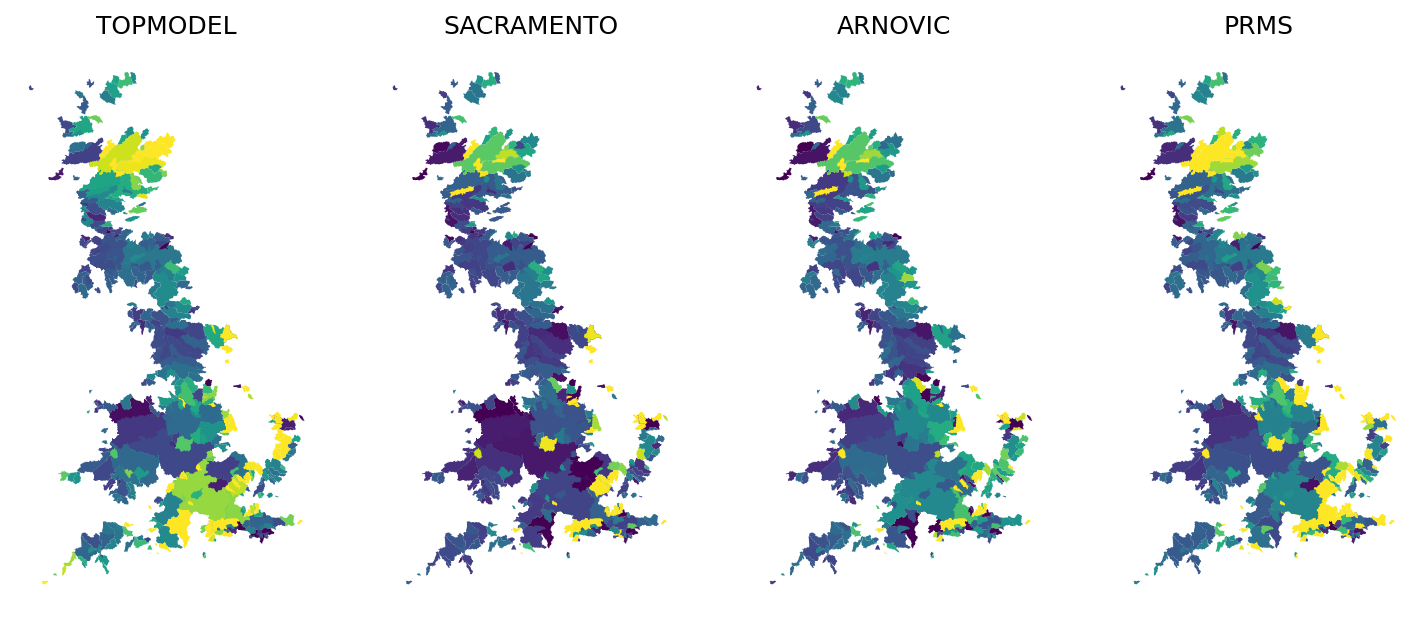

In [616]:
kwargs = {"vmin": 0, "vmax": 0.25, "cmap": "viridis"}
f, axs = plt.subplots(1, 4, figsize=(12, 8*4))
models = ["TOPMODEL", "SACRAMENTO", "ARNOVIC", "PRMS"]

for model, ax in zip(models, axs):
    delta_gdf.plot(model, ax=ax, **kwargs)
    ax.set_title(f"{model}")

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(axs[3])
# cax = divider.append_axes("right", size="5%", pad=0.1)
# delta_gdf.plot("PRMS", ax=axs[3], legend=True, cax=cax, **kwargs)

for ax in axs:
    ax.axis('off')

In [ ]:
# import geoplot as gplt
# # ?gplt.kdeplot
# f, ax = plt.subplots()
# ax = gplt.kdeplot(
#     delta_gdf, clip=uk, cmap='viridis',
# #     extent=(r.lonmin, r.latmin, r.lonmax, r.latmax),
# #     **kwargs,
# )
# # # gplt.polyplot(uk, ax=ax, zorder=1)
# # sns.kdeplot(
# #     pd.Series([p.centroid.x for p in delta_gdf.geometry]),
# #     pd.Series([p.centroid.y for p in delta_gdf.geometry]),
# #     ax=ax, shade_lowest=shade_lowest, cmap=self.cmap, **self.kwargs
# # )

# What patterns in delta nse

# Spearmans Rank Correlation between static features & DeltaNSE

In [ ]:
from scipy.stats import spearmanr
from collections import defaultdict

In [ ]:
stations = [sid for sid in delta_nse["TOPMODEL"].dropna().index]
models = ["TOPMODEL", "PRMS", "Sacramento", "VIC"]

# numerical non nan rows
static = static_df.loc[stations, (static_df.dtypes == "float64")]
static = static.loc[:, ~(static.isnull().mean(axis=0) > 0)]


all_spearmans = {}
for model in models:
    spearmans_rank = defaultdict(dict)
    for static_feature in static.columns:
        a = static_df.loc[stations, static_feature]
        b = delta_nse.loc[stations, model]
        assert a.isnull().mean() == 0, f"{static_feature}"

        res = spearmanr(a, b)
        spearmans_rank[static_feature]["correlation"] = res.correlation
        spearmans_rank[static_feature]["pvalue"] = res.pvalue

    spear_df = pd.DataFrame(spearmans_rank).T.reset_index().rename({"index": "feature"}, axis=1)
    all_spearmans[model] = spear_df

In [ ]:
f, axs = plt.subplots(4, 1, figsize=(12, 4*4))

for ix, model in enumerate(models):
    ax = axs[ix]
    # only select those with p values below X point
    sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < 0.01]

    # spear_df.reindex(spear_df["correlation"].abs().sort_values(ascending=False).index)
    sign_df.sort_values("correlation").set_index("feature")["correlation"].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_title("Correlation($Delta$NSE$_{" + model + "}$, Static Features)")
    ax.set_ylabel("$\\rho$")
    sns.despine()
    
plt.tight_layout()

In [ ]:
sign_features = {}
for model in models:
    # only select those with p values below X point
    sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < 0.01]
    sign_features[model] = sign_df["feature"].values

# features across all four models
sets = [set(v) for v in sign_features.values()]
features_for_analysis = list(sets[0].intersection(sets[1]).intersection(sets[2]).intersection(sets[3]))
features_for_analysis
len(features_for_analysis)

In [ ]:
for model in models:
    # only select those with p values below X point
    sign_df = all_spearmans[model].loc[all_spearmans[model]["pvalue"] < 0.01]

    f, ax = plt.subplots(figsize=(12, 4))
    # spear_df.reindex(spear_df["correlation"].abs().sort_values(ascending=False).index)
    sign_df.sort_values("correlation").set_index("feature")["correlation"].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_title("Correlation($Delta$NSE$_{" + model + "}$, Static Features)")
    ax.set_ylabel("$\\rho$")
    sns.despine()

In [ ]:
# Plot the normalised values of NSE vs. static feature
from sklearn.preprocessing import normalize, MinMaxScaler
stations = [sid for sid in delta_nse["TOPMODEL"].dropna().index]

norm_static = pd.DataFrame(MinMaxScaler().fit_transform(static))
norm_static.columns = static.columns
norm_static.index = static.index

delta_nse_nonans = delta_nse.dropna()
norm_nse = pd.DataFrame(MinMaxScaler().fit_transform(delta_nse_nonans))
norm_nse.columns = delta_nse_nonans.columns
norm_nse.index = delta_nse_nonans.index

n_rows = (len(features_for_analysis) // 2) + (len(features_for_analysis) % 2)
f, axs = plt.subplots(n_rows, 2, figsize=(3*2, 2*n_rows))
for ix, static_feature in enumerate(features_for_analysis):
    ax_ix = np.unravel_index(ix, (n_rows, 2))
    ax = axs[ax_ix]
    
    # get the X, y data
    sort_index = norm_nse.loc[stations, model].sort_values(ascending=True).index
    y = norm_static.loc[stations, static_feature].reindex(sort_index)
    x = norm_nse.loc[stations, model].reindex(sort_index)
    ax.scatter(x, y)
    
    # plot regression
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef) 
    y_hat = poly1d_fn(x)
    ax.plot(x, y_hat, ls=":", color="k", label=f"{coef[0]:.2f}")
    
    ax.set_title(static_feature)
    ax.legend()
    
    if ax_ix[0] == n_rows - 1:
        ax.set_xlabel("$\Delta$NSE")
    sns.despine()
    
plt.tight_layout()

# Where do we do worse?

In [ ]:
from matplotlib import colors

cmap = colors.ListedColormap(["grey", sns.color_palette()[0]])

f, axs = plt.subplots(1, 4, figsize=(12, 8*4))

for ix, model in enumerate(models):
    ax = axs[ix]
    ax.set_title(model)
    delta_gdf[f"{model}_bool"] = delta_gdf[model] < 0
    delta_gdf.plot(f"{model}_bool", ax=ax, cmap=cmap)
    
for ax in axs:
    ax.axis('off')

## Which basins do all 3 of the conceptual models outperform the LSTM

In [ ]:
conceptual_better = delta_gdf[[c for c in delta_gdf.columns if "bool" in c]]
# conceptual_better[np.any(conceptual_better, axis=1)]
worse_stations = [sid for sid in conceptual_better[np.all(conceptual_better, axis=1)].index if sid in matching_stations]
len(conceptual_better[np.all(conceptual_better, axis=1)])
len(worse_stations)

In [ ]:
station_names = fuse_errors_pub.iloc[:, 0].rename("name")

f, axs = plt.subplots(len(worse_stations), 1, figsize=(6, 3*len(worse_stations)))
for ix, sid in enumerate(lstm_preds.sel(station_id=worse_stations).station_id):
    ax = axs[ix]
    # LSTM
    lstm_preds.sel(station_id=sid, time=lstm_preds["time.year"] == 2007)["sim"].plot(ax=ax, **{"label": "LSTM", "linewidth": 1})

    # conceptual models
    fuse_d = fuse_ds.sel(station_id=sid, time=fuse_ds["time.year"] == 2007)
    for v in [str(v) for v in fuse_d.data_vars]:
        fuse_d[v].plot(ax=ax, **{"label": str(v).replace("SimQ_", ""), "linewidth": 1})
    
    # obs
    lstm_preds.sel(station_id=sid, time=lstm_preds["time.year"] == 2007)["obs"].plot(ax=ax, color="k", ls=":", **{"label": "Observation"})
    
    # title
    name = station_names.loc[int(sid)]
    nse = float(lstm_metric_df.set_index("station_id").loc[int(sid)])
    top_nse = top_error.loc[int(sid)]["nse"]
    vic_nse = vic_error.loc[int(sid)]["nse"]
    prm_nse = prms_error.loc[int(sid)]["nse"]
    sac_nse = sac_error.loc[int(sid)]["nse"]
    ax.set_title(
        f"{name}\n"
        f"LSTM: {nse:.2f} -- TOP: {top_nse:.2f} -- Sac: {sac_nse:.2f} -- PRMS: {prm_nse:.2f} -- VIC: {vic_nse:.2f}"
    )
    if ix == 0:
        ax.legend()

plt.tight_layout()
sns.despine()

## Measure the difference between Catchments - KS Test 
- [Scipy implementation](https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets)
- This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution. The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’.
- If the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same


In [ ]:
from scipy.stats import ks_2samp
from collections import defaultdict

In [ ]:
(static_df.dtypes == "float64").sum()

In [ ]:
wilcoxon_results = defaultdict(dict)
for static_feature in static_df.loc[:, static_df.dtypes == "float64"].columns:
    test_result = ks_2samp(
        static_df.loc[better_stations, static_feature],
        static_df.loc[[ix for ix in static_df.index if ix not in better_stations], static_feature]
    )
    wilcoxon_results[static_feature]["statistic"] = test_result.statistic
    wilcoxon_results[static_feature]["pvalue"] = test_result.pvalue
    
ks_df = pd.DataFrame(wilcoxon_results).T.reset_index().rename({"index": "static_feature"}, axis=1)
ks_df.head()

In [ ]:
static_for_worse = static_df.loc[better_stations, ks_df.loc[ks_df["pvalue"] < 0.05, "static_feature"]]
static_for_better = static_df.loc[[ix for ix in static_df.index if ix not in better_stations], ks_df.loc[ks_df["pvalue"] < 0.05, "static_feature"]]
display(static_for_better.head())
display(static_for_worse.head())

In [ ]:
def ecdf(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate empirical cummulative density function

    Parameters
    ----------
    x : np.ndarray
        Array containing the data

    Returns
    -------
    x : np.ndarray
        Array containing the sorted metric values
    y : np.ndarray]
        Array containing the sorted cdf values
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys

In [ ]:
f, axs = plt.subplots(16, 4, figsize=(3*4, 1*16))

static_feature = "frac_high_perc"

for ix, static_feature in enumerate(static_for_better.columns):
    ax = axs[np.unravel_index(ix, (16, 4))]
    # sns.kdeplot(static_for_better.loc[:, static_feature].dropna(), ax=ax, label="Better", shade=False, cumulative=True, legend=False if ix != 0 else True)
    # sns.kdeplot(static_for_worse.loc[:, static_feature].dropna(), ax=ax, label="Worse", shade=False, cumulative=True, legend=False if ix != 0 else True)
    ax.plot(*ecdf(static_for_better.loc[:, static_feature].dropna()))
    ax.plot(*ecdf(static_for_worse.loc[:, static_feature].dropna()))

    ax.set_title(static_feature)
    ax.axis("off")
    
plt.tight_layout()

# Bayesian Analysis supersedes the T Test (BEST)
- [BEST Python tool](https://best.readthedocs.io/en/latest/)
- [BEST in PyMC3](https://docs.pymc.io/notebooks/BEST.html)
- [Using R and Stan w/BRMS](https://vuorre.netlify.app/post/2017/01/02/how-to-compare-two-groups-with-robust-bayesian-estimation-using-r-stan-and-brms/)
- [Original Paper](https://jkkweb.sitehost.iu.edu/BEST/BEST.pdf)

# What characteristics where we do better / worse

In [ ]:
# Worse?
worse_cments_top = static_df[(lstm_delta_nse < 0)["TOPMODEL"]]
worse_cments_sac = static_df[(lstm_delta_nse < 0)["Sacramento"]]
worse_cments_vic = static_df[(lstm_delta_nse < 0)["VIC"]]
worse_cments_prms = static_df[(lstm_delta_nse < 0)["PRMS"]]

In [ ]:
# sns.distplot(worse_cments_top["aridity"], label="TOPMODEL")
# sns.distplot(worse_cments_sac["aridity"], label="Sacramento")
# sns.distplot(worse_cments_vic["aridity"], label="VIC")
# sns.distplot(worse_cments_prms["aridity"], label="PRMS")
# plt.legend()
# sns.despine()

# Train RandomForests on the model performances // Delta NSE
- [sklearn implementation](https://github.com/scikit-learn/scikit-learn/pull/13146)
- [post here](https://explained.ai/rf-importance/)
- [rfpimp package](https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py#L263)

### How this works
- $y$ = delta_NSE
- $X$ = static features

In [ ]:
from rfpimp import (
    importances, 
    plot_importances, 
    plot_corr_heatmap, 
    feature_corr_matrix, 
    feature_dependence_matrix,
    plot_dependence_heatmap
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [ ]:
grouped_features = [
    #  HydroGeology
    ["inter_high_perc", "inter_mod_perc", "inter_low_perc",],
    ["frac_high_perc", "frac_mod_perc", "frac_low_perc",],
    ["low_nsig_perc", "nsig_low_perc",],
    "no_gw_perc",
    # Topography
    ["gauge_lat", "gauge_lon",],
    [
        "gauge_elev",
        "elev_mean",
        "elev_min",
        "elev_10",
        "elev_50",
        "elev_90",
        "elev_max",
    ],
    "dpsbar",
    #  Soil Properties
    ["sand_perc", "silt_perc", "clay_perc", "organic_perc",],
    ["bulkdens", "bulkdens_5", "bulkdens_50", "bulkdens_95",],
    [
        "tawc", "tawc_5", "tawc_50", "tawc_95"
    ],
    [
        "porosity_cosby",
        "porosity_cosby_5",
        "porosity_cosby_50",
        "porosity_cosby_95",
        "porosity_hypres",
        "porosity_hypres_5",
        "porosity_hypres_50",
        "porosity_hypres_95",
    ],
    [
        "conductivity_cosby",
        "conductivity_cosby_5",
        "conductivity_cosby_50",
        "conductivity_cosby_95",
        "conductivity_hypres",
        "conductivity_hypres_5",
        "conductivity_hypres_50",
        "conductivity_hypres_95",
    ],
    ["root_depth", "root_depth_5", "root_depth_50", "root_depth_95",],
    [
        "soil_depth_pelletier",
        "soil_depth_pelletier_5",
        "soil_depth_pelletier_50",
        "soil_depth_pelletier_95",
    ],
    #  Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    ["baseflow_index", "baseflow_index_ceh",],
    "hfd_mean",
    "Q5",
    "Q95",
    ["high_q_freq", "low_q_freq", "zero_q_freq",],
    ["high_q_dur", "low_q_dur",],
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "p_seasonality",
    "frac_snow",
    "high_prec_freq",
    "high_prec_dur",
    "low_prec_freq",
    "low_prec_dur",
    #  landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
    "inwater_perc",
    "bares_perc",
    # human influence
    "surfacewater_abs",
    "groundwater_abs",
    "discharges",
]

In [ ]:
from typing import Union

def flatten(list_of_lists: List[Union[str, List]]):
    flattened = []
    for item in list_of_lists:
        if type(item) == list:
            flattened.extend([i for i in item])
        else:
            flattened.append(item)
        
    return flattened

cont_features = flatten(groups_of_colinear_features)

In [ ]:
categorical_features = [
    "dom_land_cover",
    "high_prec_timing",
    "low_prec_timing",
]
numerical_features = [
    "reservoir_cap"
]
numerical_features.extend(cont_features)

important_features = [
    # topography
    "gauge_lat", 
    "gauge_lon",
    "gauge_elev",
    "dpsbar",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]

In [ ]:
# get train pairs
Ys = delta_nse.dropna()

X = static_df.loc[:, numerical_features + categorical_features]
X = X.loc[Ys.index, important_features]

assert len(X) == len(Ys)
display(Ys.head())

In [ ]:
# Processing and fitting pipeline
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
#     ('normalizer', ),
#     ('dimensional_reduction', PCA(n_components=4))
])

preprocessing = ColumnTransformer(
    [
        ('cat', categorical_pipe, categorical_features),
        ('num', numerical_pipe, numerical_features)
    ]
)

preprocessing = ColumnTransformer(
    [
        ("num", numerical_pipe, important_features)
    ]
)

rf = Pipeline([
    ('preprocess', preprocessing),
    ('Regressor', RandomForestRegressor(random_state=1, max_features=0.1, oob_score=True))
])

In [ ]:
# categorical_pipe.fit_transform(X[categorical_features])

In [ ]:
rf.fit(X, Ys);

In [ ]:
importances(rf, X, Ys)

In [ ]:
print("RF train accuracy: %0.3f" % rf.score(X, Ys))

In [ ]:
result = permutation_importance(rf, X, Ys, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

In [ ]:
def scatter_plot_feature(feature: str):
    f, ax = plt.subplots()
    d = delta_nse.join(static_df[feature])

    ax.scatter(d[feature], d["TOPMODEL"], marker="x", label="TOPMODEL", alpha=0.5, color=sns.color_palette()[0])
    ax.scatter(d[feature], d["Sacramento"], marker="x", label="Sacramento", alpha=0.5, color=sns.color_palette()[1])
    ax.scatter(d[feature], d["VIC"], marker="x", label="VIC", alpha=0.5, color=sns.color_palette()[2])
    ax.scatter(d[feature], d["PRMS"], marker="x", label="PRMS", alpha=0.5, color=sns.color_palette()[3])
    
    # plot linear regressions
    # m, b = np.polyfit(d[feature], d["TOPMODEL"], 1)

    ax.set_ylim(-1, 1)
    ax.set_ylabel("$\Delta$NSE")
    ax.set_xlabel(feature)
    plt.legend()
    sns.despine()
    

scatter_plot_feature("crop_perc")